In [1]:
from fklearn.training.classification import lgbm_classification_learner
from fklearn.validation.perturbators import perturbator, nullify, sample_columns
from fklearn.validation.validator import validator
from fklearn.validation.evaluators import auc_evaluator
from fklearn.validation.splitters import out_of_time_and_space_splitter
from fklearn.training.pipeline import build_pipeline
from datetime import datetime
from toolz import curry
import random
import pandas as pd
random.seed(42)

# Fixed

In [2]:
#All in this cell was imported from the current healbot3 model

SELECTED_FEATURES = ['stddev_asset__revolving_balance_0_30',
                     'amount_agreement_mean',
                     'current_days_delinquent',
                     'scr__cartao_de_credito_compra_lojista_days_since_first_relations',
                     'max_asset__installments_issuer_balance_0_90',
                     'max_payment_90',
                     'boavista_consult__score_bvnt',
                     'sum_limit_request_time_weight_180',
                     'mean_previous_delinquencies_amount_weight_180',
                     'profit_and_loss__credit_loss_recovery_balance',
                     'std_payments_180',
                     'avg_asset__late_balance_0_180',
                     'sum_limit_request_time_weight',
                     'std_payments',
                     'scr__late_balance_over_customer__updated_reported_income',
                     'customer__updated_reported_income_with_attachment_fixed',
                     'score_utilization',
                     'latitude',
                     'customer_age',
                     'boavista_consult__score_bvrenda',
                     'sum_spends',
                     'email_event_30',
                     'count_call_direction__inbound_30',
                     'scr__limit_balance',
                     'serasa_consult__cnu_1_score',
                     'scpc_debts_60',
                     'mean_previous_delinquencies_duration_90',
                     'charge_amount_agreement_mean',
                     'profit_and_loss__credit_loss_balance',
                     'avg_call_duration_30',
                     'avg_asset__installments_issuer_balance_0_30',
                     'charges_agreement_mean',
                     'boavista_consult__score_bv10',
                     'ongoing_agreement_amount',
                     'count_previous_delinquencies',
                     'asset__pre_loss_balance',
                     'current_days_delinquent_90',
                     'mean_previous_delinquencies_duration_weight_90',
                     'max_asset__late_balance_0_30',
                     'stddev_asset__late_balance_0_90',
                     'count_payments_180',
                     'max_asset__late_balance_0_90',
                     'ongoing_agreement_discount',
                     'geo_risk_v2',
                     'avg_asset__late_balance_0_30',
                     'scr__current_balance',
                     'avg_spend_outros',
                     'serasa_consult__bpip_income',
                     'chat_event_30',
                     'scr__short_term_debt',
                     'scr__current_balance_over_customer__updated_reported_income_lagged_2',
                     'scr__late_balance_over_current_balance_lagged_1',
                     'max_payment_180',
                     'max_asset__installments_merchant_balance_0_180',
                     'ongoing_agreement_days_since_start',
                     'score_utilized',
                     'days_since_last_chat',
                     'count_payments',
                     'geo_risk',
                     'positives_asset__late_balance_0_180',
                     'scr__late_balance_over_current_balance_lagged_2',
                     'serasa_consult__income',
                     'scr__limites_de_credito_days_since_first_relations',
                     'avg_asset__installments_merchant_balance_0_90',
                     'ongoing_agreement_charges',
                     'scr__current_balance_lagged_1',
                     'scr__limites_de_credito_limite_credito_lagged_1',
                     'mean_previous_delinquencies_duration_weight',
                     'mean_previous_delinquencies_duration_180',
                     'max_asset__installments_issuer_balance_0_30',
                     'asset__late_balance',
                     'score_max_credit_limit',
                     'ongoing_agreement_downpayment',
                     'scr__limit_balance_over_customer__updated_reported_income',
                     'current_days_delinquent_180',
                     'scr__long_term_debt_over_customer__updated_reported_income_lagged_1',
                     'stddev_asset__late_balance_0_180',
                     'mean_previous_delinquencies_amount_weight_90',
                     'avg_spends',
                     'avg_asset__late_balance_0_90',
                     'avg_asset__installments_issuer_balance_0_90',
                     'stddev_asset__late_balance_0_30',
                     'mean_previous_delinquencies_duration',
                     'stddev_asset__revolving_balance_0_90',
                     'serasa_consult__csba_score',
                     'mean_payments_90',
                     'scr__limites_de_credito_limite_credito_lagged_2',
                     'scr__late_balance_over_current_balance',
                     'avg_asset__installments_issuer_balance_0_180',
                     'avg_asset__installments_merchant_balance_0_180',
                     'ongoing_agreement_charge_amount',
                     'scr__limites_de_credito_limite_credito_venc_time_weighted',
                     'asset__installments_issuer_balance',
                     'count_payments_90',
                     'stddev_asset__installments_issuer_balance_0_90',
                     'days_since_last_email',
                     'scr__if_quantity',
                     'positives_asset__installments_issuer_balance_0_90',
                     'asset__revolving_balance',
                     'scr__long_term_debt_lagged_1',
                     'downpayment_agreement_mean',
                     'positives_asset__late_balance_0_90',
                     'scr__limit_balance_lagged_2',
                     'registry_quantity_60',
                     'mean_previous_delinquencies_amount_weight',
                     'boavista_consult__score_bvrec',
                     'discount_agreement_mean',
                     'scr__limites_de_credito_limite_credito',
                     'serasa_consult__score',
                     'positives_asset__late_balance_0_30',
                     'std_payments_90',
                     'scr__short_term_debt_lagged_2',
                     'max_payment',
                     'scr__late_balance_over_customer__updated_reported_income_lagged_1',
                     'mean_previous_delinquencies_duration_weight_180',
                     'avg_asset__revolving_balance_0_30',
                     'longitude',
                     'scr__limit_balance_lagged_1',
                     'asset__renegotiated_balance',
                     'boavista_consult__score_bvnu']

LR = 0.01
N_ESTIM = 1000
EXTRA_PARAMETERS = { "max_depth": 7,
                     "num_leaves": 70,
                     "feature_fraction": 0.5,
                     "min_data_in_leaf": 100,
                     "reg_alpha": 9e-08,
                     "subsample": 0.85,
                     "seed": 4224,
                     "min_child_weight": 20,
                     "min_gain_to_split": 0.5,
                     "nthread": -1,
                     "verbose": -1}

In [3]:
#hack to read just a part of the dataset

#skiprows function
@curry
def coin_toss(i, true_perc: float) -> bool:
    if i == 0: #read column names 
        return False
    
    if random.random() < true_perc:
        return True
    return False

def train_test_ratio(fn_out):
    folds = fn_out[0]
    for i, fold in enumerate(folds):
        tr_ratio = len(fold[0]) / (len(fold[0]) + len(fold[1][0]))
        print(f'split {i} train ratio: {tr_ratio}')

In [4]:
skip_fn = coin_toss(true_perc=0.95) # get 80% of dataset skipped
df = pd.read_csv('../../macacaos/data/sample.csv',infer_datetime_format=True, skiprows=skip_fn)
df['score_date'] = pd.to_datetime(df['score_date'])

# AUC vs Percentage of null columns 🤔

Mean across runs in blue, 2 stds boundary in red

(There might be a weird effect happening because

a) we're only using 20% of data

b) the out of time and space splitter is too aggressive)

In [5]:
#balanced?
limit = pd.to_datetime("2018-12-01T00:00:00.000Z")
my_split_fn = out_of_time_and_space_splitter(n_splits = 2,
                                            in_time_limit=limit,
                                            time_column="score_date",
                                            space_column="collection__id"
                                            )
train_test_ratio(my_split_fn(df))


split 0 train ratio: 0.7652684024429444
split 1 train ratio: 0.76408


In [16]:
from tqdm import tqdm_notebook
import numpy as np

train_fn = build_pipeline(
    lgbm_classification_learner(features=SELECTED_FEATURES, target='target', learning_rate=LR,
                                        num_estimators=N_ESTIM, extra_params=EXTRA_PARAMETERS))

limit = pd.to_datetime("2018-12-01T00:00:00.000Z")
my_split_fn = out_of_time_and_space_splitter(n_splits = 2,
                                            in_time_limit=limit,
                                            time_column="score_date",
                                            space_column="collection__id"
                                            )

auc_eval_fn = auc_evaluator(prediction_column="prediction",
                          target_column="target")

RES = 25
RUNS_PER_RES = 3
runs = []
threshs = np.linspace(0, 1, RES)
for thresh in tqdm_notebook(threshs):
    for i in range(RUNS_PER_RES):
        logs = []
        corr_cols = sample_columns(df[SELECTED_FEATURES], thresh)
        perturb_fn = perturbator(cols = corr_cols, corruption_fn = nullify())
        log = validator(df,
                      split_fn=my_split_fn,
                      train_fn=train_fn,
                      eval_fn=auc_eval_fn,
                      perturb_fn_train=perturb_fn)
        logs.append(log)
    runs.append(logs)

In [17]:
def parse_metric(log):
    metric = 'auc_evaluator__target'
    parsed = []
    for fold in log['validator_log']:
        parsed.append(fold['eval_results'][0][metric])
    return parsed

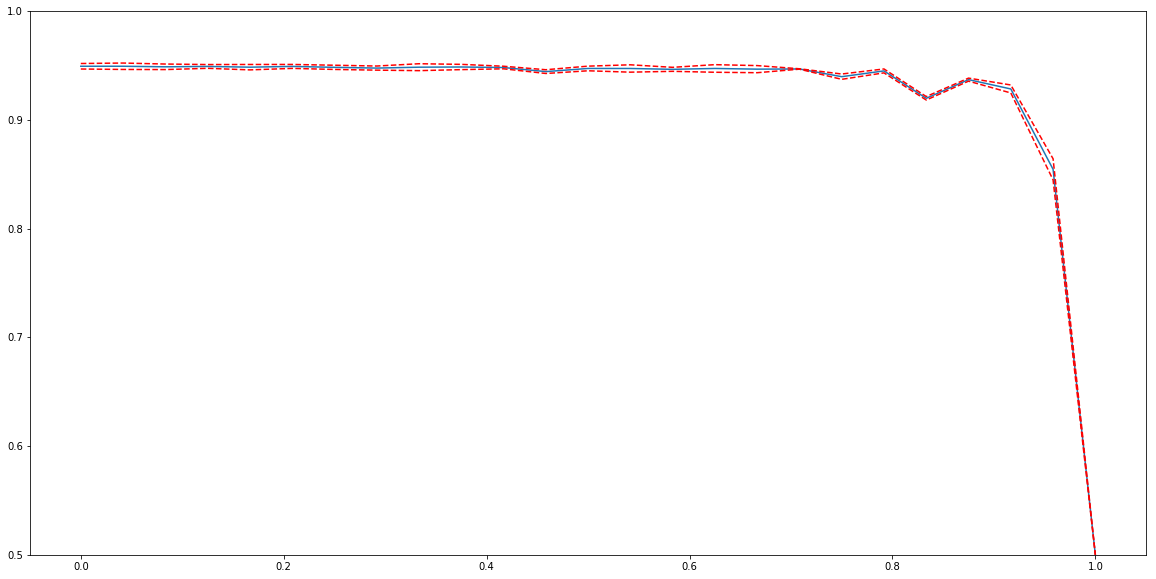

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
means = []
stds = []

for thresh, run in zip(threshs, runs):
    metrics = []
    for sample in run:
        metrics += parse_metric(sample)
    stds.append(np.std(metrics))
    means.append(np.mean(metrics))
    
means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(20,10))
plt.ylim(0.5, 1)

plt.plot(threshs, means)
plt.plot(threshs, means + 2*stds, 'r--')
plt.plot(threshs, means - 2*stds, 'r--')
plt.show()